### play game func

In [6]:
import numpy as np
import torch
from agent import Agent
from board import Board
from model import ConnectFourNN

def select_action(state, model:ConnectFourNN, epsilon):
    """
    Returns: col, reward\n
    a move chosen with eps-greedy policy and punishment for illegal moves 
    """
    reward = 0
    if np.random.rand() < epsilon:
        valid_moves = []
        for i in range(state.shape[1]):
            if state[0][i] == 0:
                valid_moves.append(i)
        return np.random.choice(valid_moves), reward
    else:
        with torch.no_grad():
            model.eval()
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            action_sorted = model(state_tensor).argsort(descending=True)
            for col in action_sorted[0]:
                if state[0][col] == 0:
                    return col, reward
                reward -= 0.15

def play_exp_game(agent1:Agent, agent2:Agent, type = 'greedy', eps = 0):
    """
    # Returns:
    list of experience from the game from both players
    """

    board = Board()
    agent1.board = board
    agent2.board = board
    curr_agent = agent2
    done = False

    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []

    while not done:
        curr_agent = agent1 if curr_agent != agent1 else agent2
        eps = eps if curr_agent == agent1 else 0

        state = curr_agent.get_board_state()
        action = curr_agent.choose_action(state, type='greedy', eps=eps)
        reward = curr_agent.perform_action(action)
        
        # update previous player if he lost or drew
        if reward == Board.rewards_dict['win']:
            rewards[-1] = Board.rewards_dict['loss']
        elif reward == Board.rewards_dict['draw']:
            rewards[-1] = Board.rewards_dict['draw']

        next_states.append(state)
        actions.append(action)
        rewards.append(reward)
        states.append(state)
        dones.append(reward != Board.rewards_dict['valid_move'])

        done = dones[-1]
    
    next_states.append(state)
    next_states.append(state)

    exp_list = []
    for i in range(len(rewards)):
        # next state is added with offset=2
        exp_list.append((states[i], actions[i], rewards[i], next_states[i+2], done))

    return exp_list


def play_eval_game(main_agent:Agent, test_agent:Agent) -> int:
    """
    mask_moves: bool
     if `True` model is allowed to choose valid action\n
     if `False` model loses when choosing invalid action 
    # Returns:
    `1` - model win \n
    `0` - draw \n
    `-1` - test_model win \n
    """
    
    board = Board()
    main_agent.board = board
    test_agent.board = board
    curr_agent = test_agent
    done = False

    while not done:
        curr_agent = main_agent if curr_agent != main_agent else test_agent

        state = curr_agent.get_board_state()
        action = curr_agent.choose_action(state, type='greedy', eps=0)
        reward = curr_agent.perform_action(action)

        done = (reward != Board.rewards_dict['valid_move'])

    if reward == Board.rewards_dict['win']:
        return 1 if curr_agent == main_agent else -1
    elif reward == Board.rewards_dict['illegal_move']:
        return -1 if curr_agent == main_agent else 1
    elif reward == Board.rewards_dict['draw']:
        return 0

### Train step func

In [7]:
import random
import torch.nn as nn

def train_step(main_model, target_model, optimizer, replay_buffer, gamma, batch_size, loss_class):
    if len(replay_buffer) < batch_size:
        return 0
    
    main_model.train()

    batch = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    # equal_flags = [np.array_equal(states[i], next_states[i]) for i in range(len(states))]

    states = torch.tensor(np.array(states), dtype=torch.float32).unsqueeze(1)
    actions = torch.tensor(np.array(actions), dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(np.array(rewards), dtype=torch.float32)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32).unsqueeze(1)
    dones = torch.tensor(np.array(dones), dtype=torch.int8)
    # dones = torch.tensor([1 if flag else 0 for flag in equal_flags])

    q_values = main_model(states).gather(1, actions).squeeze()

    next_q_values = target_model(next_states).max(1)[0]
    target_q_values = rewards + gamma * next_q_values * dones

    loss = loss_class()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.detach().numpy()

# Hyper Parameters

In [8]:
import torch.nn as nn

# TODO fine tune
eps = 1
eps_min = 0.05
eps_decay = 0.9999
epochs = 2*10**4
batch_size = 64 * 8
train_freq = 1
target_update_freq = 10
checkpoint_freq = epochs // 5
gamma = 0.99
lr = 3.3e-6

# TODO TEST OTHER
# loss_class = nn.MSELoss
loss_class = nn.HuberLoss


# Initialize Models

In [9]:
from model import ConnectFourNN
from replay_buffer import ReplayBuffer
import torch.optim as optim

def initialize_weights_he(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

main_model = ConnectFourNN()
main_model.apply(initialize_weights_he)

target_model = ConnectFourNN()
target_model.load_state_dict(main_model.state_dict())
target_model.eval()

replay_buffer = ReplayBuffer()

optimizer = optim.Adam(main_model.parameters(), lr = lr)

agent1 = Agent(main_model, piece_tag=1)
agent2 = Agent(main_model, piece_tag=2)

test_agent = Agent(torch.load("models/red_cp5_050724-055355.pth"), piece_tag=2)

# Training Loop

  0%|          | 69/20000 [00:01<06:59, 47.48it/s]c:\Users\cp\anaconda3\Lib\site-packages\torch\autograd\__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 20%|█▉        | 3999/20000 [35:16<2:14:17,  1.99it/s]

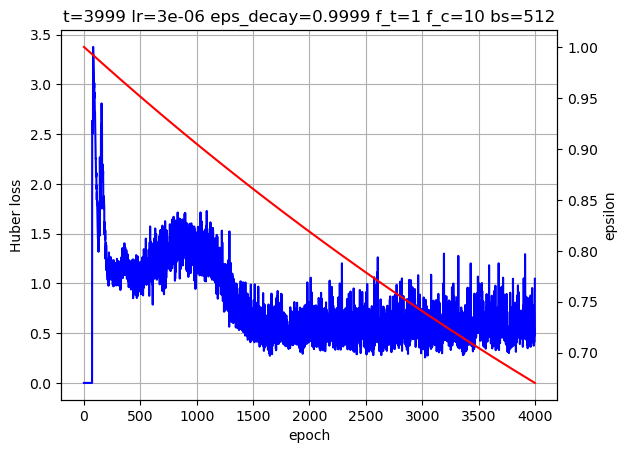

 40%|███▉      | 7999/20000 [1:09:41<1:48:01,  1.85it/s]

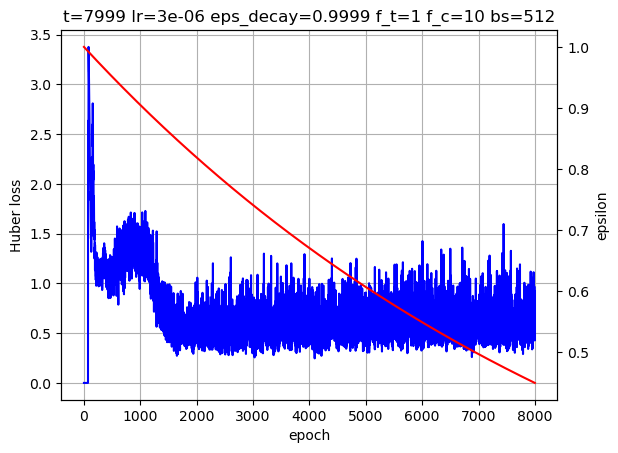

 60%|█████▉    | 11999/20000 [1:43:44<1:03:41,  2.09it/s]

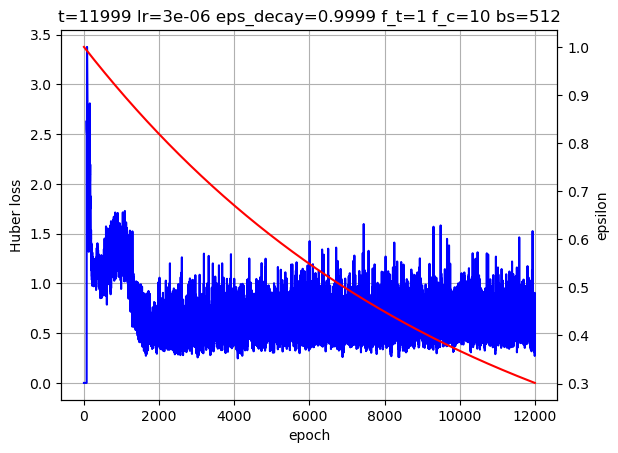

 80%|███████▉  | 15999/20000 [2:18:03<37:03,  1.80it/s]  

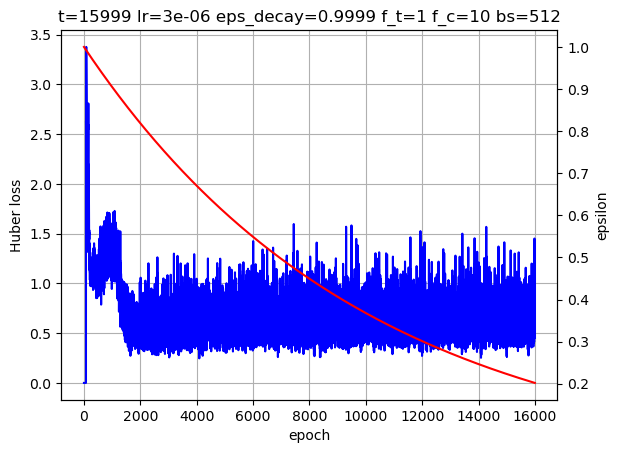

100%|█████████▉| 19999/20000 [2:53:00<00:00,  1.82it/s]

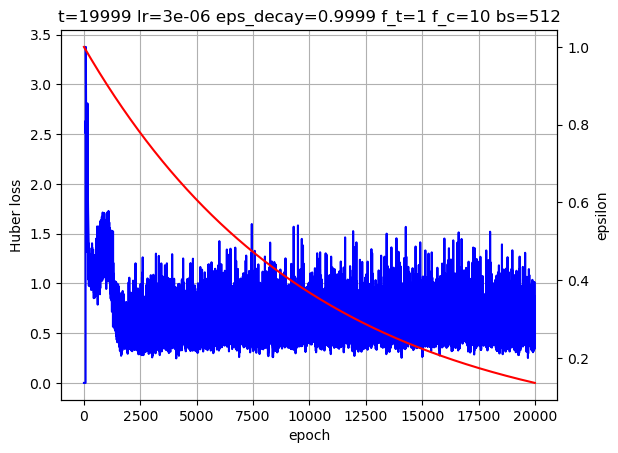

100%|██████████| 20000/20000 [2:53:01<00:00,  1.93it/s]


In [10]:
from datetime import datetime
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

losses = []
times = []
EPS = []
results = []
points = 0

for t in tqdm(range(epochs)):
    exp_list = play_exp_game(agent1, agent2, eps)
    replay_buffer.extend(exp_list)

    if not t % train_freq:
        loss = train_step(main_model, target_model, optimizer, replay_buffer, gamma, batch_size, loss_class)

        if len(replay_buffer) > 10000:
            replay_buffer.clear_oldest(train_freq * len(exp_list))

        times.append(t)
        losses.append(loss)
        EPS.append(eps)

    if not t % target_update_freq:
        target_model.load_state_dict(main_model.state_dict())
                
    if not (t+1) % checkpoint_freq:
        stamp = datetime.now().strftime("%d%m%y-%H%M%S")
        path = rf'models/cp{t//checkpoint_freq}_{stamp}.pth'
        torch.save(main_model, path)

        plt.clf()
        plt.plot(times, losses, 'b-')
        plt.xlabel("epoch")
        plt.ylabel("Huber loss")
        plt.grid()
        ax2 = plt.twinx()
        ax2.plot(times, EPS, 'r-')
        ax2.set_ylabel('epsilon')
        plt.title(f't={t} lr={lr:.0e} eps_decay={eps_decay} f_t={train_freq} f_c={target_update_freq} bs={batch_size}')
        plt.show()

    eps = max(eps_min, eps_decay * eps)

In [11]:
agent1.get_actions_pred(agent1.get_board_state()).squeeze()[1].item()

1.9567136764526367